## Checking the compilation with the GPU

In [4]:
import torch

print("CUDA disponible :", torch.cuda.is_available())

print("GPU utilisé :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun GPU")

CUDA disponible : True
GPU utilisé : Tesla T4


## Loading data

In [5]:
import os

# Path to the dataset folder
dataset_path = "/kaggle/input/fingerprint-data/Merge_data"

# List files in the dataset directory
print("Files in dataset:", os.listdir(dataset_path))



Files in dataset: ['AB-', 'O+', 'B-', 'B+', 'A-', 'A+', 'O-', 'AB+']


## Importing the libraries

In [6]:
from ast import increment_lineno

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

import pandas as pd

## Splitting the Dataset into train and validation

In [7]:
# Load the data
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # the directory
    labels="inferred",  # using the labels that exist in the folders
    label_mode="categorical",  # one-hot encoding
    batch_size=32,
    image_size=(60, 60),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="training"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # the directory
    labels="inferred",  # using the labels that exist in the folders
    label_mode="categorical",  # one-hot encoding
    batch_size=32,
    image_size=(60, 60),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="validation"
)

# Print class names before applying any transformations
print("Training class names:", ds_train.class_names)
print("Validation class names:", ds_val.class_names)




Found 30000 files belonging to 8 classes.
Using 18000 files for training.
Found 30000 files belonging to 8 classes.
Using 12000 files for validation.
Training class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
Validation class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


## Data Normalization

In [9]:
# Normalize the datasets (apply map function to normalize images)
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply normalization
ds_train = ds_train.map(normalize)
ds_val = ds_val.map(normalize)

# Display the number of batches in each dataset
print('The number of batches in train set:', tf.data.experimental.cardinality(ds_train).numpy())
print('The number of batches in validation set:', tf.data.experimental.cardinality(ds_val).numpy())

The number of batches in train set: 563
The number of batches in validation set: 375


## Another split for data testing

In [10]:
# devide the val data set into val and test data set 
val_batches = tf.data.experimental.cardinality(ds_val)
ds_test = ds_val.take(val_batches // 2)
ds_validation = ds_val.skip(val_batches // 2)

In [11]:
# displaying the shapes :
print('the number of batches in train set :', tf.data.experimental.cardinality(ds_train))
print('the number of batches in validation set :', tf.data.experimental.cardinality(ds_validation))
print('the number of batches in test set :', tf.data.experimental.cardinality(ds_test))

the number of batches in train set : tf.Tensor(563, shape=(), dtype=int64)
the number of batches in validation set : tf.Tensor(188, shape=(), dtype=int64)
the number of batches in test set : tf.Tensor(187, shape=(), dtype=int64)


## ResNet50 Model's functions 

In [12]:
#convolutional_block
def convolutional_block(x, filters, kernel_size=3, stride=2):
    """
    Convolutional block with a skip connection for ResNet architecture.
    Args:
    - x: input tensor
    - filters: number of filters for the convolutional layers
    - kernel_size: size of the convolution filter (default is 3)
    - stride: stride size for the convolution (default is 2)
    """
    # Save the input tensor for the skip connection
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolutional layer
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # If the stride is not 1, we apply a 1x1 convolution to the shortcut
    if stride != 1:
        shortcut = layers.Conv2D(filters=filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the skip connection (shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x


In [13]:
#identity_block
def identity_block(x, filters, kernel_size=3):
    """
    Identity block (the residual block where dimensions are unchanged).
    Args:
    - x: input tensor
    - filters: number of filters for the convolutional layers
    - kernel_size: size of the convolution filter (default is 3)
    """
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add the skip connection (shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

In [14]:
#ResNet50
def ResNet50(input_shape=(60, 60, 3), num_classes=8):
    """
    ResNet50-like model built from scratch.
    Args:
    - input_shape: shape of the input images (default is (60, 60, 3))
    - num_classes: number of output classes (default is 8)
    """
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Block
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    # Block 1
    x = convolutional_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = layers.Dropout(0.5)(x)
    # Block 2
    x = convolutional_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)

    # Block 3
    x = convolutional_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    # Block 4
    x = convolutional_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)

    return model

In [15]:
# Build the ResNet50 model
model_resnet = ResNet50(input_shape=(60, 60, 3), num_classes=8)

# Display the model summary
model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 60, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │      4,160 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 8, 8, 64)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,005,320 (68.68 MB)

 Trainable params: 17,991,752 (68.63 MB)

 Non-trainable params: 13,568 (53.00 KB)

## Model compilation 

In [16]:
opt = tf.keras.optimizers.SGD(learning_rate = 0.0015)
model_resnet.compile(
    

    optimizer=opt,

    loss='categorical_crossentropy',

    metrics=['accuracy']

)


history_resnet = model_resnet.fit(

    ds_train,  # training data generator

    validation_data=ds_validation,  # validation data generator

    epochs=20  # Number of epochs

)

Epoch 1/20


I0000 00:00:1738172534.118147     118 service.cc:145] XLA service 0x7a1d3c055080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738172534.118223     118 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1738172534.118229     118 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/563 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.0964 - loss: 3.3181 

I0000 00:00:1738172545.083058     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - accuracy: 0.1616 - loss: 2.6058 - val_accuracy: 0.1373 - val_loss: 2.5841
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.2421 - loss: 1.9891 - val_accuracy: 0.2889 - val_loss: 1.7743
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.2838 - loss: 1.8046 - val_accuracy: 0.2552 - val_loss: 1.9689
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3145 - loss: 1.7156 - val_accuracy: 0.3270 - val_loss: 1.6811
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3427 - loss: 1.6461 - val_accuracy: 0.3880 - val_loss: 1.5309
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.3627 - loss: 1.5971 - val_accuracy: 0.4274 - val_loss: 1.4659
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3809 - loss: 1.5467 - val_accuracy: 0.3931 - val_loss: 1.5743
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4010 - loss: 1.5078 - val_accurac

In [17]:
history_resnet = model_resnet.fit(

    ds_train,  # training data generator

    validation_data=ds_validation,  # validation data generator

    epochs=10  # Number of epochs

)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7724 - loss: 0.6137 - val_accuracy: 0.7455 - val_loss: 0.7388
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7799 - loss: 0.5906 - val_accuracy: 0.7084 - val_loss: 0.8936
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7897 - loss: 0.5627 - val_accuracy: 0.7312 - val_loss: 0.7707
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8084 - loss: 0.5354 - val_accuracy: 0.8157 - val_loss: 0.4824
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8043 - loss: 0.5272 - val_accuracy: 0.7834 - val_loss: 0.5974
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8056 - loss: 0.5100 - val_accuracy: 0.6980 - val_loss: 0.9318
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8260 - loss: 0.4759 - val_accuracy: 0.7008 - val_loss: 1.0148
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8308 - loss: 0.4591 - 

## Evalutation test of Resnet50

In [18]:
model_resnet.evaluate(ds_test)

187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8385 - loss: 0.4313


[0.4282989501953125, 0.8409090638160706]

## Training history of ResNet50 

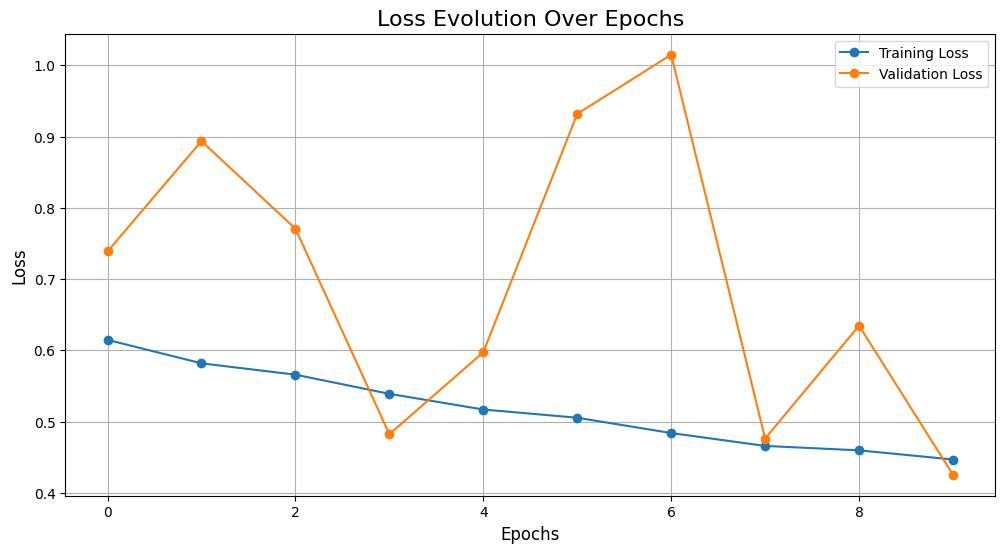

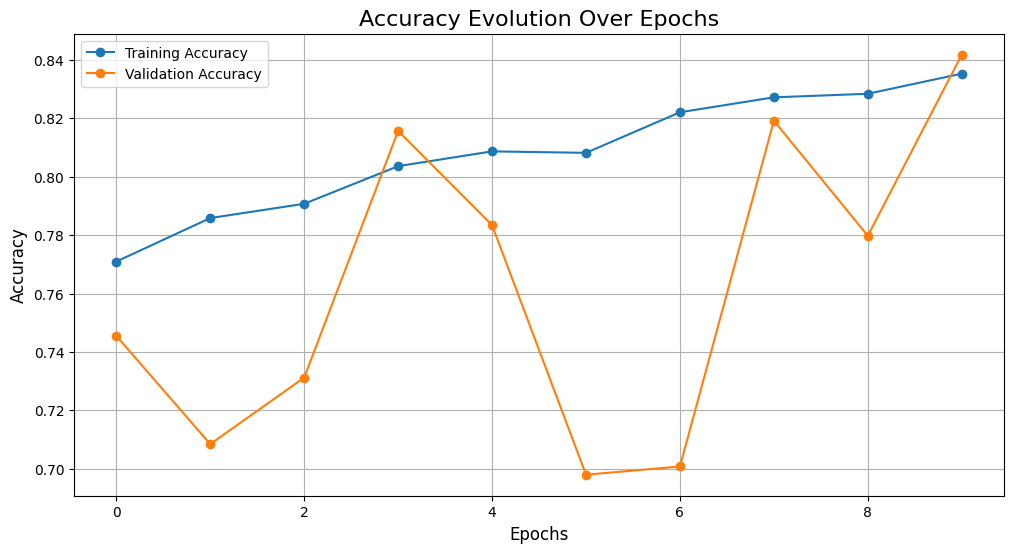

In [19]:
# Assuming `history` contains the training history (from previous training)
history_dict = history_resnet.history

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Evolution Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Evolution Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()


## Confusion Matrix 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

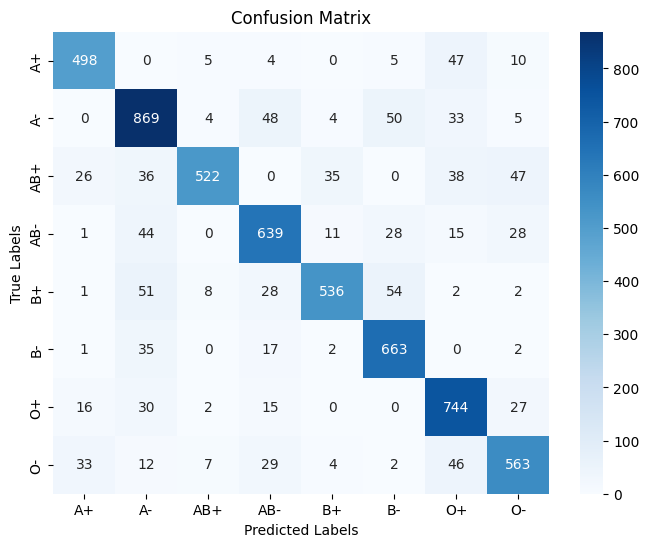

In [20]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Path to the dataset directory (the parent directory containing the class subfolders)
dataset_dir = dataset_path

# Extract class names by listing subdirectories
class_names = os.listdir(dataset_dir)
class_names.sort()  # Sorting to ensure class names are ordered consistently

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset
for images, labels in ds_test:
    # Get the true labels
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model_resnet.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(true_labels, axis=1), pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## ResNet50 Metrics (Precision, Recall and F1-score)

In [21]:

from sklearn.metrics import f1_score, precision_score, recall_score
# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset (ds_test)
for images, labels in ds_test:
    # Get the true labels (one-hot encoded)
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model_resnet.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Calculate Precision, Recall, and F1 Score with weighted average
precision = precision_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')

# Print the weighted metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# If you want individual class scores (not averaged)
precision_per_class = precision_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
recall_per_class = recall_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
f1_per_class = f1_score(np.argmax(true_labels, axis=1), pred_labels, average=None)

# Assuming you have class names, you can print individual scores per class
print("\nPrecision per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {precision_per_class[i]:.4f}')

print("\nRecall per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {recall_per_class[i]:.4f}')

print("\nF1 Score per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {f1_per_class[i]:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

## Splitting the Dataset and adjusting the appropriate image size for VGG Model inspired  

In [22]:
# Load the data
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # the directory
    labels="inferred",  # using the labels that exist in the folders
    label_mode="categorical",  # one-hot encoding
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="training"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # the directory
    labels="inferred",  # using the labels that exist in the folders
    label_mode="categorical",  # one-hot encoding
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="validation"
)

# Print class names before applying any transformations
print("Training class names:", ds_train.class_names)
print("Validation class names:", ds_val.class_names)

Found 30000 files belonging to 8 classes.
Using 18000 files for training.
Found 30000 files belonging to 8 classes.
Using 12000 files for validation.
Training class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
Validation class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


## Data Normalization

In [23]:
# Normalize the datasets (apply map function to normalize images)
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply normalization
ds_train = ds_train.map(normalize)
ds_val = ds_val.map(normalize)

# Display the number of batches in each dataset
print('The number of batches in train set:', tf.data.experimental.cardinality(ds_train).numpy())
print('The number of batches in validation set:', tf.data.experimental.cardinality(ds_val).numpy())

The number of batches in train set: 563
The number of batches in validation set: 375


## Test split

In [24]:
# devide the val data set into val and test data set 
val_batches = tf.data.experimental.cardinality(ds_val)
ds_test = ds_val.take(val_batches // 2)
ds_validation = ds_val.skip(val_batches // 2)

In [25]:
# displaying the shapes :
print('the number of batches in train set :', tf.data.experimental.cardinality(ds_train))
print('the number of batches in validation set :', tf.data.experimental.cardinality(ds_validation))
print('the number of batches in test set :', tf.data.experimental.cardinality(ds_test))

the number of batches in train set : tf.Tensor(563, shape=(), dtype=int64)
the number of batches in validation set : tf.Tensor(188, shape=(), dtype=int64)
the number of batches in test set : tf.Tensor(187, shape=(), dtype=int64)


## VGGInspired Model

In [30]:
#VGGinspired
from tensorflow.keras import layers, models

def VGGInspiredModel(input_shape=(64, 64, 3), num_classes=8):
    """
    CNN model inspired by VGG.
    Args:
    - input_shape: shape of the input images (default is (64, 64, 3))
    - num_classes: number of output classes (default is 8)
    Returns:
    - model: A Keras Model instance
    """
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  

    # Block 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  

    # Block 3
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  

    # Block 4
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x) 

    # Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)

    return model

# Instantiate the model
model_vgg = VGGInspiredModel(input_shape=(64, 64, 3), num_classes=8)

# Compile the model


# Model Summary
model_vgg.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,013,576 (34.38 MB)

 Trainable params: 9,013,576 (34.38 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.00015)
model_vgg.compile(
    

    optimizer=opt,

    loss='categorical_crossentropy',

    metrics=['accuracy']

)

history = model_vgg.fit(

    ds_train,  # training data generator

    validation_data=ds_validation,  # validation data generator

    epochs=10  # Number of epochs

)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.1758 - loss: 2.0245 - val_accuracy: 0.2694 - val_loss: 1.7448
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.2931 - loss: 1.7347 - val_accuracy: 0.5588 - val_loss: 1.1937
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.6195 - loss: 1.0196 - val_accuracy: 0.8030 - val_loss: 0.5544
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.7937 - loss: 0.5815 - val_accuracy: 0.8487 - val_loss: 0.3954
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.8330 - loss: 0.4704 - val_accuracy: 0.8612 - val_loss: 0.3632
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.8619 - loss: 0.3989 - val_accuracy: 0.8529 - val_loss: 0.3862
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.8743 - loss: 0.3487 - val_accuracy: 0.8605 - val_loss: 0.3706
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.8892 - loss: 0.3178 - 

In [32]:
model_vgg.evaluate(ds_test)

187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8754 - loss: 0.3674


[0.37374112010002136, 0.8679812550544739]

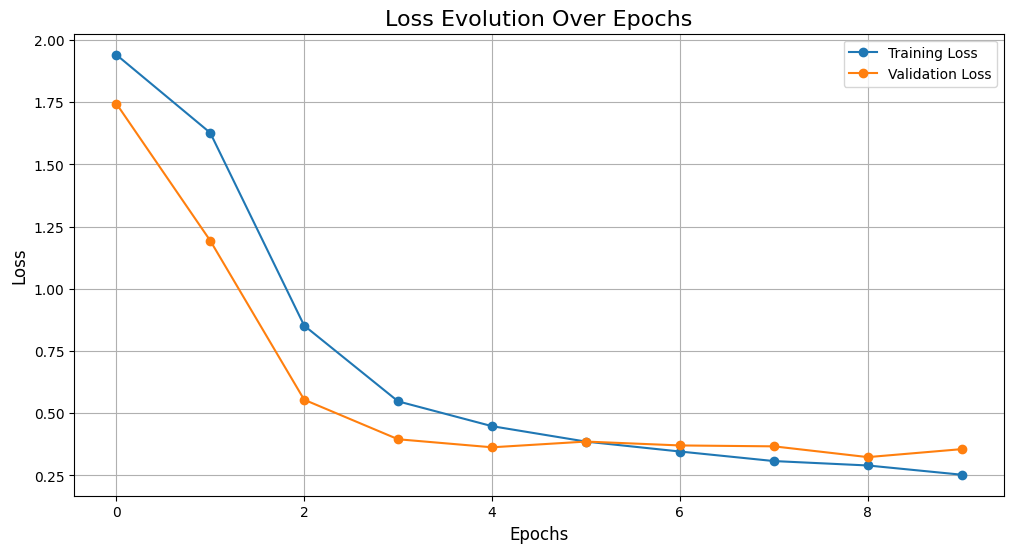

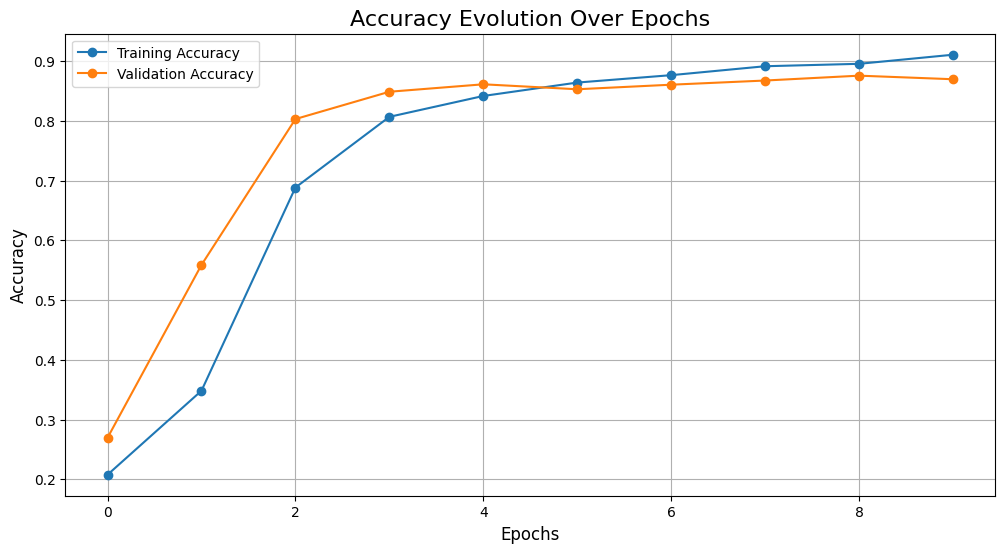

In [33]:
# Assuming `history` contains the training history (from previous training)
history_dict = history.history

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Evolution Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Evolution Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()


## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

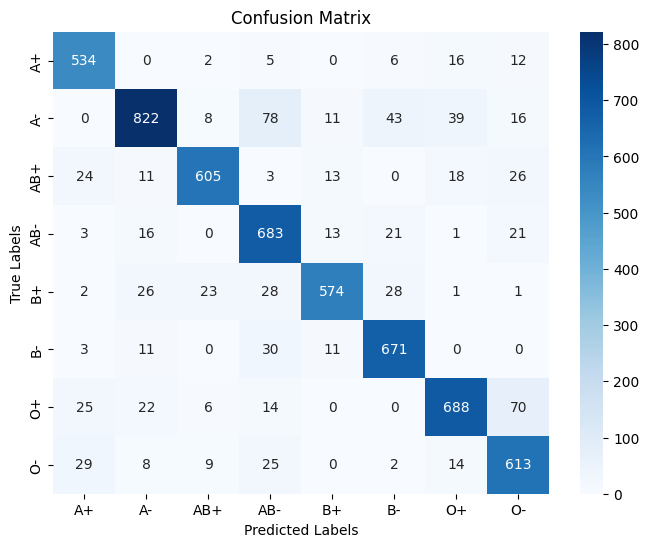

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Path to the dataset directory (the parent directory containing the class subfolders)
dataset_dir = dataset_path

# Extract class names by listing subdirectories
class_names = os.listdir(dataset_dir)
class_names.sort()  # Sorting to ensure class names are ordered consistently

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset
for images, labels in ds_test:
    # Get the true labels
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model_vgg.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(true_labels, axis=1), pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## VGG Model Metrics

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset (ds_test)
for images, labels in ds_test:
    # Get the true labels (one-hot encoded)
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model_vgg.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Calculate Precision, Recall, and F1 Score with weighted average
precision = precision_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')

# Print the weighted metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# If you want individual class scores (not averaged)
precision_per_class = precision_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
recall_per_class = recall_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
f1_per_class = f1_score(np.argmax(true_labels, axis=1), pred_labels, average=None)

# Assuming you have class names, you can print individual scores per class
print("\nPrecision per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {precision_per_class[i]:.4f}')

print("\nRecall per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {recall_per_class[i]:.4f}')

print("\nF1 Score per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {f1_per_class[i]:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

## Saving the Model

In [36]:
# Save in the HDF5 format

model_vgg.save("fingerprint_model.h5")
print("Model saved as fingerprint_model.h5")

"""
# Save in the SavedModel format
model.save(dataset_path)
print("Model saved in TensorFlow SavedModel format at 'saved_model_fingerprint'")
"""

Model saved as fingerprint_model.h5


'\n# Save in the SavedModel format\nmodel.save(dataset_path)\nprint("Model saved in TensorFlow SavedModel format at \'saved_model_fingerprint\'")\n'

In [37]:
from tensorflow.keras.models import load_model

model = load_model("fingerprint_model.h5")
print("Model loaded from fingerprint_model.h5")


Model loaded from fingerprint_model.h5
